# **Single feature version!**

## **Imports**

In [ ]:
import pandas as pd
from random import randint
import numpy as np

## **Read the data.**

In [ ]:
data = pd.read_csv('CRYPTOCURRENCY_COINDESK_BTCUSD_NEW.csv')

## **Feature Engineering!**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [ ]:
data['day_number'] = data.index.values + 1

## **Data Cleaning**

In [ ]:
data['Close'] = data['Close'].apply(lambda s: s.replace(',', ''))
data['Close'] = data['Close'].astype('float32')

## **Add Polynomial Features**

10 different degree of polynomial!

In [ ]:
fn = ['day_number']
an = ['day_number']
powers = 10

for i in range(2, powers+1):
  data['d'+str(i)] = data['day_number'] ** i
  fn.append('d'+str(i))
  an.append('d'+str(i))
  
an.append('Close')

In [ ]:
data

,Date,Close,day_number,d2,d3,d4,d5,d6,d7,d8,d9,d10
0,2020-10-11,11350.0,1,1,1,1,1,1,1,1,1,1
1,2020-10-12,11564.0,2,4,8,16,32,64,128,256,512,1024
2,2020-10-13,11437.0,3,9,27,81,243,729,2187,6561,19683,59049
3,2020-10-14,11396.0,4,16,64,256,1024,4096,16384,65536,262144,1048576
4,2020-10-15,11544.0,5,25,125,625,3125,15625,78125,390625,1953125,9765625
...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-10-07,54205.0,362,131044,47437928,17172529936,6216455836832,2250357012933184,814629238681812608,-252120776536661760,965999262276200960,-796404456496733184
362,2021-10-08,53951.0,363,131769,47832147,17363069361,6302794178043,2287914286629609,830512886046548067,6328272455544122465,-8680107851177497205,3514086626901840921
363,2021-10-09,54651.0,364,132496,48228544,17555190016,6390089165824,2325992456359936,846661254115016704,-5409952755196297216,4578812995469836288,6480963717160763392
364,2021-10-10,55425.0,365,133225,48627125,17748900625,6478348728125,2364597285765625,863078009304453125,1428824143063013153,5011978154132355597,3144362961064182921


## **Normalize the data**

In [ ]:
max_v = np.amax(np.array(data[an].values), axis=0)
min_v = np.amin(np.array(data[an].values), axis=0)
mean_v = np.mean(np.array(data[an].values), axis=0)

In [ ]:
def normalize(X):
  return (X - np.mean(X, axis=0)) / (np.amax(X, axis=0) - np.amin(X, axis=0))

In [ ]:
data[an] = normalize(np.array(data[an].values))

In [ ]:
data

,Date,Close,day_number,d2,d3,d4,d5,d6,d7,d8,d9,d10
0,2020-10-11,-0.525500,-0.500000,-0.334696,-0.251368,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
1,2020-10-12,-0.521389,-0.497260,-0.334673,-0.251368,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
2,2020-10-13,-0.523829,-0.494521,-0.334636,-0.251367,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
3,2020-10-14,-0.524616,-0.491781,-0.334584,-0.251367,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
4,2020-10-15,-0.521774,-0.489041,-0.334517,-0.251365,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-10-07,0.297575,0.489041,0.643566,0.716202,0.755627,0.778501,0.791965,0.799590,-0.040284,0.018275,-0.045446
362,2021-10-08,0.292696,0.491781,0.648978,0.724243,0.766245,0.791647,0.807590,0.817644,0.319626,-0.508362,0.190846
363,2021-10-09,0.306140,0.494521,0.654405,0.732328,0.776952,0.804939,0.823431,0.836000,-0.322387,0.215520,0.353484
364,2021-10-10,0.321006,0.497260,0.659847,0.740458,0.787747,0.818377,0.839491,0.854660,0.051654,0.239169,0.170578


## **Split the data**

Here, I splited the data in two part(train, val).
First of all, the cength of each part were calculated, then while the length of list of selected indexes is not equal to length of validation part, the while continues, when the lengths are equal, i took the every parts by their indexes!

In [ ]:
def train_val_split(data, p):
  length = len(data)
  t_l = int(length * p)

  l = []
  while len(l) != length - t_l:
    t = randint(0, length-1)
    if t not in l:
      l.append(t)

  X_val =  data.loc[l]
  y_val = data.loc[l]  
  X_val =  X_val[fn]
  y_val = y_val[['Close']]


  X_train = data.drop(l)
  y_train = data.drop(l)
  X_train = X_train[fn]
  y_train = y_train[['Close']]
  return X_train, y_train, X_val, y_val

In [ ]:
X_train, y_train, X_valid, y_valid = train_val_split(data, 0.8)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid =  np.array(X_valid)
y_valid = np.array(y_valid)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(292, 10)
(292, 1)
(74, 10)
(74, 1)


## **Model**

In [ ]:
def cost_function(y, p):
  m = len(y)
  cost = (1 / m) * np.sum(np.multiply((y - p),(y - p)))
  return cost

In [ ]:
def calc_derivative(X, y, p):
  w_d = (-2 / len(X)) * np.dot(X.transpose(), (y - p))
  b_d = (-2 / len(X)) * np.sum((y - p))
  return w_d, b_d

In [ ]:
def predict(X, W, b):
  return np.dot(X, W) + b

In [ ]:
def gradient_descent(X, y, X_valid, y_valid, n_itrs = 15000, alpha = 0.001):
  W = np.zeros((X.shape[1], 1))
  b = 1
  valid_costs = []
  costs = []
  derivatives = []
  for i in range(n_itrs):
    p = predict(X, W, b)

    cost = cost_function(y, p)
    costs.append(cost)

    v_c = cost_function(y_valid, predict(X_valid, W, b))
    valid_costs.append(v_c)
      
    derv_w, derv_b = calc_derivative(X, y, p)
    derivatives.append([derv_w, derv_b])

    W -= alpha * derv_w
    b -= alpha * derv_b
    
  return W, b, costs, derivatives

## **Try the model for 20 different degrees of the polynomial.**

In [ ]:
costs = []
Ws = []
bs = []
mc = 10
i_a = -1

for i in range(powers):
  
  W, b, costs_i, derivatives = gradient_descent(X_train[:, : (i + 1)], y_train, X_valid[:, :(i + 1)], y_valid, n_itrs = 1000000 + 10000 * i)
  p = predict(X_valid[:, : (i + 1) ], W, b)
  c = cost_function(y_valid, p)
  if c < mc:
    mc = c
    Ws=W
    bs = b
    i_a = i
  print(i, ' : ',c)
print(i_a)

0  :  0.05228975489869381
1  :  0.029437950951853063
2  :  0.030204002333721638
3  :  0.024939142076282932
4  :  0.019583916992695356
5  :  0.017544383086856928
6  :  0.01769099303251347
7  :  0.017861507399158007
8  :  0.017883221681514436
9  :  0.01753984551180936
9


In [ ]:
data.iloc[:, 2:(i_a + 3)]

,day_number,d2,d3,d4,d5,d6,d7,d8,d9,d10
0,-0.500000,-0.334696,-0.251368,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
1,-0.497260,-0.334673,-0.251368,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
2,-0.494521,-0.334636,-0.251367,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
3,-0.491781,-0.334584,-0.251367,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
4,-0.489041,-0.334517,-0.251365,-0.201369,-0.168036,-0.144227,-0.126370,-0.026494,-0.034464,-0.001789
...,...,...,...,...,...,...,...,...,...,...
361,0.489041,0.643566,0.716202,0.755627,0.778501,0.791965,0.799590,-0.040284,0.018275,-0.045446
362,0.491781,0.648978,0.724243,0.766245,0.791647,0.807590,0.817644,0.319626,-0.508362,0.190846
363,0.494521,0.654405,0.732328,0.776952,0.804939,0.823431,0.836000,-0.322387,0.215520,0.353484
364,0.497260,0.659847,0.740458,0.787747,0.818377,0.839491,0.854660,0.051654,0.239169,0.170578


Comparing the actual and predicted values.

In [ ]:
p = predict(np.array(data.iloc[:, 2:(i_a + 3)]), Ws, bs)

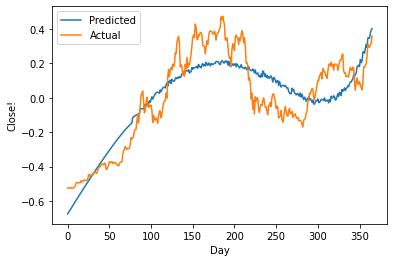

In [ ]:
import matplotlib.pyplot as plt

plt.plot(p, label= 'Predicted')
plt.plot(data['Close'], label= 'Actual')
plt.legend(loc='best')
plt.xlabel('Day')
plt.ylabel('Close!')
plt.show()